In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.8'

# Problem 1. 

Examine the CNN for the basic binary classification on Kaggle.com dog_vs_cats dataset. That CNN has 4 convolutional layers, 4 max_pooling layers, 1 flatten layer and 2 dense layers. Keep original cells with code and results unmodified so that you could use them for comparison. Add new cells for modified definition and training of your model. Add an L1 regularizer on next to the last Dense layer. That is the Dense layer with (512,1) output tensor. As the regularization lambda, use the value of 0.0001. Run your model for 15 epochs and compare it with the original result on the model without regularization. Present the plots of training and validation accuracies and let us know whether regularization alleviate the overfitting and to what extent. Save your model as an H5 file. Keep H5 file for future reference. Do not submit H5 file as part of your solution.

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

In [2]:
import os, shutil

In [11]:
#create directories

# The path to the directory where the original dataset was uncompressed
original_dataset_dir = '/Users/Matt/CS89/train'

# The directory where we will
# store our smaller dataset
base_dir = 'cats_and_dogs_small'
os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [12]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [13]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [14]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total validation cat images: 500


In [15]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [16]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [17]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same 
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one 
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a 
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is 
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [10]:
#original model
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [11]:
#original model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

# Add an L1 regularizer on next to the last Dense layer. That is the Dense layer with (512,1) output tensor. As the regularization lambda, use the value of 0.0001. 

In [19]:
#modified model
from keras import layers
from keras import models
from keras import regularizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#add L1 regularizer to the following dense layer
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
#modified model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to 
use in various situations).

In [21]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [22]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [23]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [15]:
#original model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 9s - loss: 0.6898 - acc: 0.5285 - val_loss: 0.6724 - val_acc: 0.5950
Epoch 2/30
100/100 [==============================] - 8s - loss: 0.6543 - acc: 0.6340 - val_loss: 0.6565 - val_acc: 0.5950
Epoch 3/30
100/100 [==============================] - 8s - loss: 0.6143 - acc: 0.6690 - val_loss: 0.6116 - val_acc: 0.6650
Epoch 4/30
100/100 [==============================] - 8s - loss: 0.5626 - acc: 0.7125 - val_loss: 0.5774 - val_acc: 0.6970
Epoch 5/30
100/100 [==============================] - 8s - loss: 0.5266 - acc: 0.7335 - val_loss: 0.5726 - val_acc: 0.6960
Epoch 6/30
100/100 [==============================] - 8s - loss: 0.5007 - acc: 0.7550 - val_loss: 0.6075 - val_acc: 0.6580
Epoch 7/30
100/100 [==============================] - 8s - loss: 0.4723 - acc: 0.7840 - val_loss: 0.5516 - val_acc: 0.7060
Epoch 8/30
100/100 [==============================] - 8s - loss: 0.4521 - acc: 0.7875 - val_loss: 0.5724 - val_acc: 0.6980
Epoch 9/30
100/1

# Run your model for 15 epochs and compare it with the original result on the model without regularization. Present the plots of training and validation accuracies and let us know whether regularization alleviate the overfitting and to what extent. Save your model as an H5 file. Keep H5 file for future reference.

In [24]:
#modified model with 15 epochs

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50)

/var/folders/c8/t3508_w11p5b02z3sd_69m1w0000gr/T/ipykernel_69426/2428620691.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
100/100 [==============================] - 64s 624ms/step - loss: 4.0597 - acc: 0.5100 - val_loss: 2.9428 - val_acc: 0.5000
Epoch 2/15
100/100 [==============================] - 65s 654ms/step - loss: 2.1708 - acc: 0.5625 - val_loss: 1.5395 - val_acc: 0.6000
Epoch 3/15
100/100 [==============================] - 67s 673ms/step - loss: 1.2192 - acc: 0.5990 - val_loss: 1.0483 - val_acc: 0.5340
Epoch 4/15
100/100 [==============================] - 72s 716ms/step - loss: 0.9421 - acc: 0.6230 - val_loss: 0.8837 - val_acc: 0.6230
Epoch 5/15
100/100 [==============================] - 78s 778ms/step - loss: 0.8360 - acc: 0.6695 - val_loss: 0.8032 - val_acc: 0.6640
Epoch 6/15
100/100 [==============================] - 73s 725ms/step - loss: 0.7793 - acc: 0.6730 - val_loss: 0.7908 - val_acc: 0.6410
Epoch 7/15
100/100 [==============================] - 72s 721ms/step - loss: 0.7374 - acc: 0.7070 - val_loss: 0.7481 - val_acc: 0.6770
Epoch 8/15
100/100 [==============================] - 7

It is good practice to always save your models after training:

In [25]:
model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

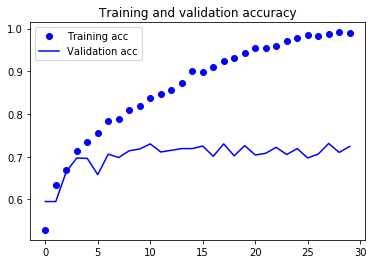

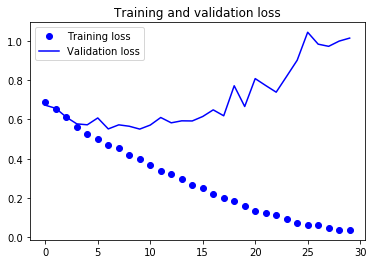

In [34]:
#original results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

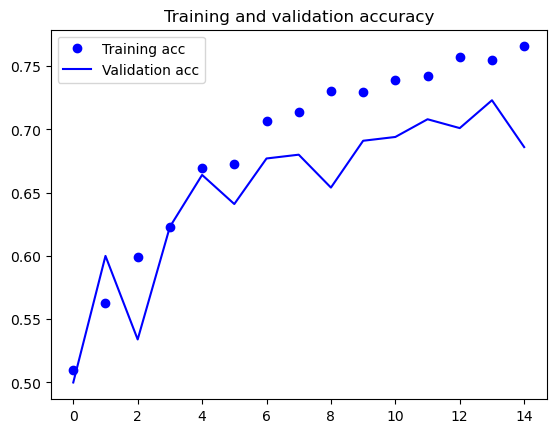

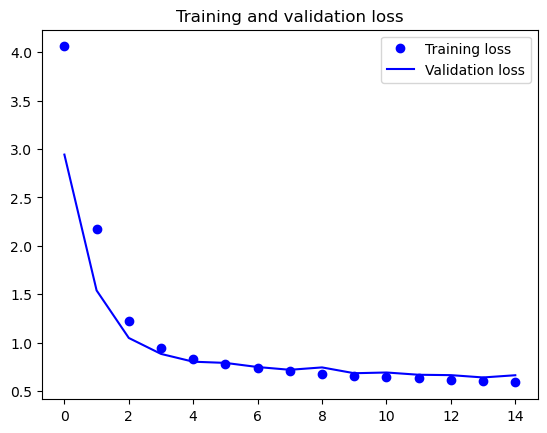

In [26]:
#modified results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.

## As we see in the charts above, the modified model with an L1 regularizer has some improvements in terms of the overfitting observed through the first 15 epochs; we obvserve much less difference in training accuracy and loss from validation accuracy and loss than we do in the original charts.

# Problem 2. Replace all but the very first Conv2D layers with SeparableConv2D layers. Add BatchNormalization after those SeparableConv2D layers. Train that new model. Do it for 60 epochs. Report on the number of trainable parameters in that new model as compared with the original model. Report on other results. Is new model more precise or less. Is overfitting reduced or not. 

In [30]:
#modified separable conv model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#replace subsequent conv layers with separable conv layers, add batch normalization
model.add(layers.SeparableConv2D(128, 3, padding='same', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.SeparableConv2D(128, 3, padding='same', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#add L1 regularizer to the following dense layer
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
model.add(layers.Dense(1, activation='sigmoid'))

In [31]:
#modified sepconv model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_2 (Separab  (None, 36, 36, 128)      8768      
 leConv2D)                                                       
                                                      

### Original Model: Total params: 3,453,121, Trainable params: 3,453,121

### Modified SepConv2d model: Total params: 5,356,161, Trainable params: 5,355,649.  The number of parameters actually increased in our Separable Convolution model, primarily due to the final dense layer.  However, number of parameters decreased in each of the convolution layers that were replaced with separable convolution layers.

In [32]:
#compile new separable conv model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [33]:
#new separable conv model with 60 epochs

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=60,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/60
100/100 [==============================] - 59s 561ms/step - loss: 6.0738 - acc: 0.5820 - val_loss: 5.0460 - val_acc: 0.5000
Epoch 2/60
100/100 [==============================] - 60s 596ms/step - loss: 4.0417 - acc: 0.6890 - val_loss: 3.3604 - val_acc: 0.5000
Epoch 3/60
100/100 [==============================] - 60s 597ms/step - loss: 2.7812 - acc: 0.7185 - val_loss: 2.6101 - val_acc: 0.5000
Epoch 4/60
100/100 [==============================] - 60s 603ms/step - loss: 2.2733 - acc: 0.7445 - val_loss: 2.2963 - val_acc: 0.5010
Epoch 5/60
100/100 [==============================] - 61s 606ms/step - loss: 1.9935 - acc: 0.7565 - val_loss: 2.0714 - val_acc: 0.5410
Epoch 6/60
100/100 [==============================] - 61s 609ms/step - loss: 1.7803 - acc: 0.7905 - val_loss: 1.8559 - val_acc: 0.6690
Epoch 7/60
100/100 [==============================] - 62s 618ms/step - loss: 1.5888 - acc: 0.8185 - val_loss: 1.8190 - val_acc: 0.5860
Epoch 8/60
100/100 [==============================] - 6

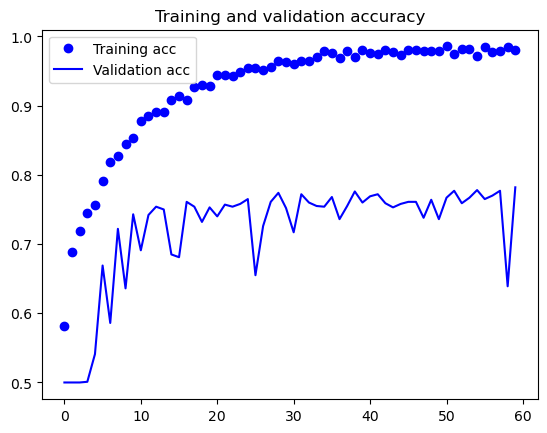

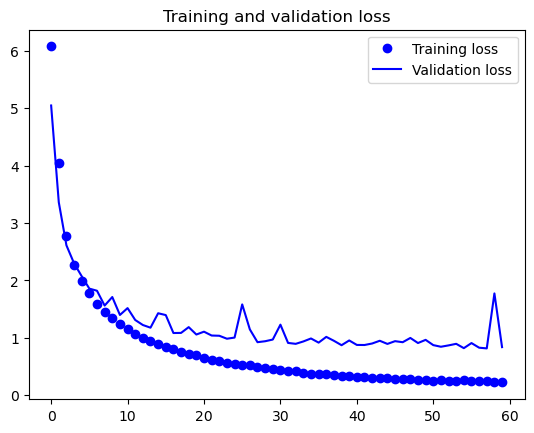

In [34]:
#sep conv results

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### In the modified model using separable convolutional layers, we see validation accuracy increase to ~76% from the previous (regularized) model's ~71% validation accuracy.  However, we see overfitting begin around the 10th epoch, which is an improvement from the original code, but approximately on par with the regularized model.  This latter is difficult to evaluate exactly as we only trained the regularized model for 15 epochs. 

# Problem 3. Demonstrate image augmentation for an image of your choice. Produce one modified image for every one of these options separately: rotation_range, width_shift, shear_range, zoom_range, vertical_flip, and horizontal_flip. Reference notebooks generate images which have random transformations along all of those option axes. You are asked to perform one transformation at a time.

In [ ]:
#reference code

# This is module with image preprocessing utilities 
from tensorflow.keras import utils
fnames =[os.path.join(train_cats_dir,fname)
for fname in os.listdir(train_cats_dir)] # We pick one image to "augment"
img_path = fnames[5]
# Read the image and resize it
img = utils.load_img(img_path, target_size=(150, 150)) # Convert it to a Numpy array with shape (150, 150, 3) 
x = utils.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)
# The .flow() command below generates batches of randomly transformed images. # It will loop indefinitely, so we need to `break` the loop at some point! 
i=0
for batch in datagen.flow(x, batch_size=1):
plt.figure(i)
imgplot = plt.imshow(image.array_to_img(batch[0])) i += 1
if i % 4 == 0:
    break

In [45]:
#load reference image and preprocess
from tensorflow.keras import utils

fnames =[os.path.join(train_dogs_dir,fname) for fname in os.listdir(train_dogs_dir)]
img_path = fnames[5]
img = utils.load_img(img_path, target_size=(150,150))
x = utils.img_to_array(img)
x= x.reshape((1,)+x.shape)

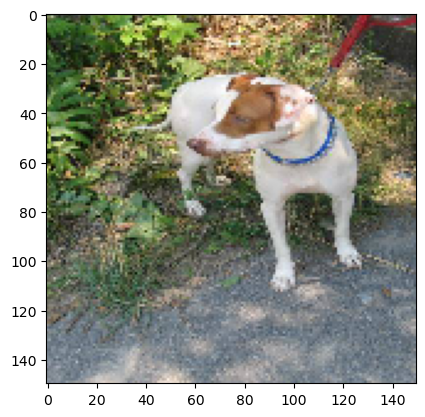

In [52]:
plt.imshow(img)

In [57]:
#define function for producing modified images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

def gen_img(datagen):
    batch = datagen.flow(x, batch_size=1)
    plt.imshow(image.array_to_img(batch[0][0,:,:])) 
    plt.show()

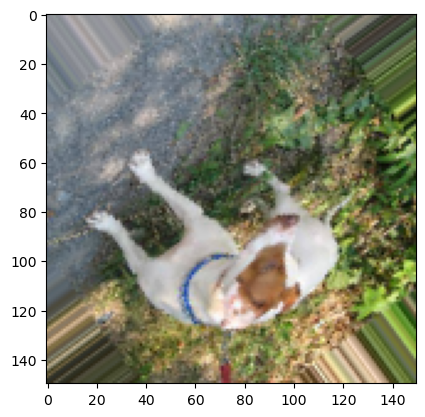

In [63]:
#rotation range modification

datagen = ImageDataGenerator(
      rotation_range=180,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=0,
      zoom_range=0,
      horizontal_flip=False,
      fill_mode='nearest')

gen_img(datagen)


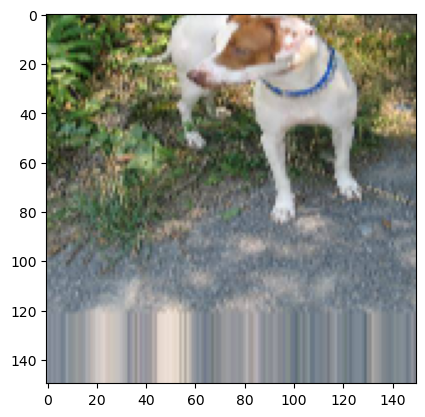

In [65]:
#width shift modification

datagen = ImageDataGenerator(
      rotation_range=0,
      width_shift_range=.3,
      height_shift_range=0,
      shear_range=0,
      zoom_range=0,
      horizontal_flip=False,
      fill_mode='nearest')

gen_img(datagen)

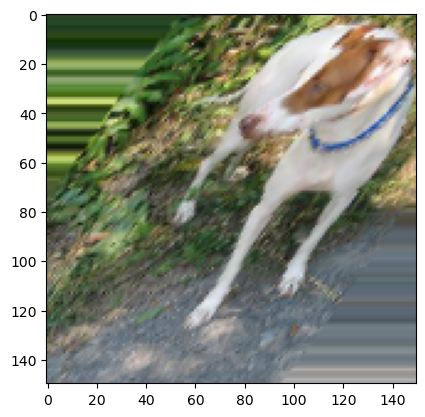

In [87]:
#shear range modification

datagen = ImageDataGenerator(
      rotation_range=0,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=200,
      zoom_range=0,
      horizontal_flip=False,
      fill_mode='nearest')

gen_img(datagen)

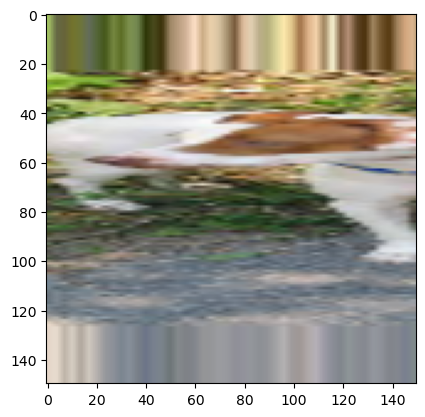

In [83]:
#zoom range modification

datagen = ImageDataGenerator(
      rotation_range=0,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=0,
      zoom_range=.9,
      horizontal_flip=False,
      fill_mode='nearest')

gen_img(datagen)

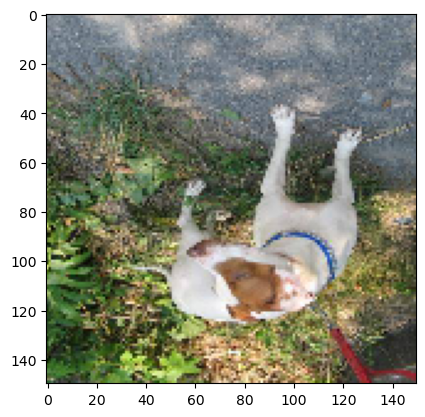

In [82]:
#vertical flip modification

datagen = ImageDataGenerator(
      rotation_range=0,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=0,
      zoom_range=0,
      horizontal_flip=False,
      vertical_flip=True,
      fill_mode='nearest')

gen_img(datagen)

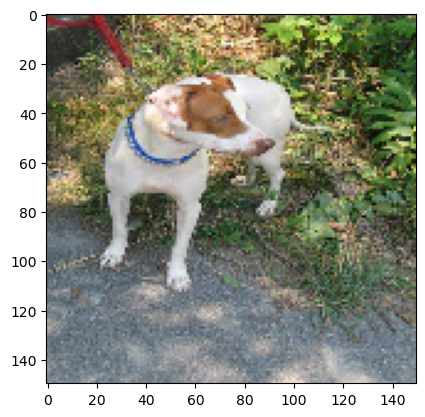

In [78]:
#horizontal flip modification

datagen = ImageDataGenerator(
      rotation_range=0,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=0,
      zoom_range=0,
      horizontal_flip=True,
      fill_mode='nearest')

gen_img(datagen)

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [35]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

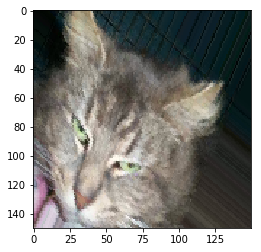

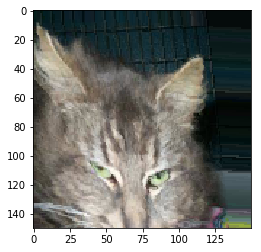

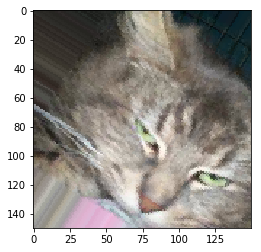

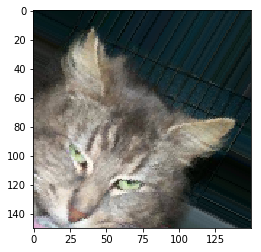

In [36]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [37]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [38]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 24s - loss: 0.6857 - acc: 0.5447 - val_loss: 0.6620 - val_acc: 0.5888
Epoch 2/100
100/100 [==============================] - 23s - loss: 0.6710 - acc: 0.5675 - val_loss: 0.6606 - val_acc: 0.5825
Epoch 3/100
100/100 [==============================] - 22s - loss: 0.6609 - acc: 0.5913 - val_loss: 0.6663 - val_acc: 0.5711.594 - ETA: 7s - loss: 0.6655 - ETA: 5s - los - ETA: 1s - loss: 0.6620 - acc: 
Epoch 4/100
100/100 [==============================] - 22s - loss: 0.6446 - acc: 0.6178 - val_loss: 0.6200 - val_acc: 0.6379
Epoch 5/100
100/100 [==============================] - 22s - loss: 0.6267 - acc: 0.6325 - val_loss: 0.6280 - val_acc: 0.5996
Epoch 6/100
100/100 [==============================] - 22s - loss: 0.6080 - acc: 0.6631 - val_loss: 0.6841 - val_acc: 0.5490
Epoch 7/100
100/100 [==============================] - 22s - loss: 0.5992 - acc: 0.6700 

Let's save our model -- we will be using it in the section on convnet visualization.

In [41]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

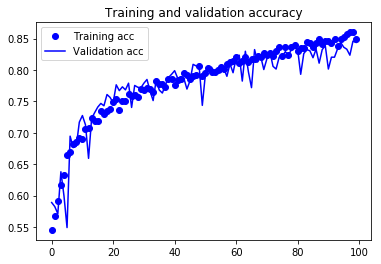

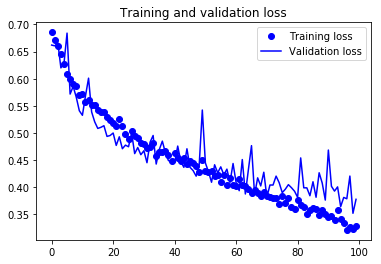

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution 
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove 
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a 
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two 
sections.